In [70]:
import os, sys
import pandas as pds
from dask import dataframe as dd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## load harmonized entity-attribute-value file
* first load into pandas
* second load into dask for better performance

In [2]:
df = pds.read_csv('../../target/harmonized-values-eav.tsv.zip', sep='\t')

In [3]:
ddf = dd.from_pandas(df, npartitions=8)

In [4]:
ddf = ddf.reset_index()

In [5]:
ddf.head()

,index,biosample,attribute,value
0,0,SAMN00000002,collection_date,not determined
1,1,SAMN00000002,estimated_size,2550000
2,2,SAMN00000002,host,Homo sapiens
3,3,SAMN00000002,lat_lon,not determined
4,4,SAMN00000002,env_broad_scale,terrestrial biome [ENVO:00000446]


In [6]:
ddf.columns

Index(['index', 'biosample', 'attribute', 'value'], dtype='object')

In [18]:
ddf.info()

<class 'dask.dataframe.core.DataFrame'>
Columns: 4 entries, index to value
dtypes: object(3), int64(1)

### compute the number of biosamples

In [167]:
biosamples = []
for b in ddf['biosample'].unique().compute():
    biosamples.append(b)

In [168]:
len(biosamples)

13791009

### compute number of times an attribute occurres

In [48]:
attributes = {}
for a in ddf['attribute'].unique().compute():
    attributes[a] = 0

In [49]:
attributes['env_broad_scale']

0

In [50]:
for a in ddf['attribute']:
    attributes[a] = (attributes[a] + 1)

In [51]:
attributes['env_broad_scale'] # test of one record

1537375

In [63]:
attrCountDf = pds.DataFrame(data={'attribute': list(attributes.keys()), 'count': list(attributes.values())})

In [67]:
attrCountDf.query("attribute == 'env_broad_scale'") # test of one record

,attribute,count
4,env_broad_scale,1537375


In [74]:
len(attrCountDf)

447

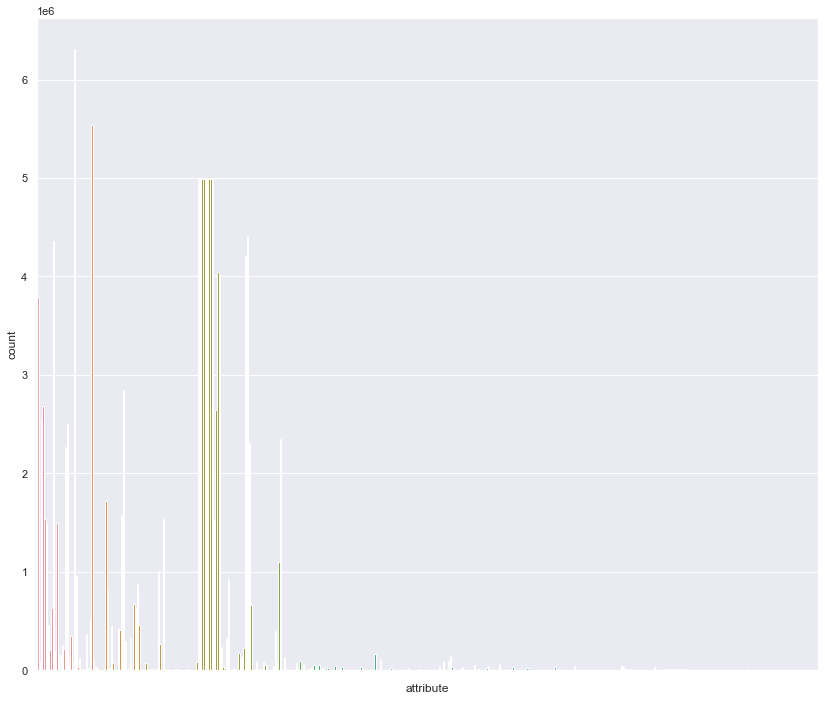

In [104]:
%matplotlib inline
sns.set()

colors=['blue']
sns.set_palette('GnBu_d')

plt.figure(figsize=(14,12))

ax = sns.barplot(x='attribute', y='count', data=attrCountDf)
xticks = [''] * 447
ax.set_xticklabels(xticks, size=1)
plt.show()

In [92]:
top50Df = attrCountDf.sort_values(by='count', ascending=False).head(50)

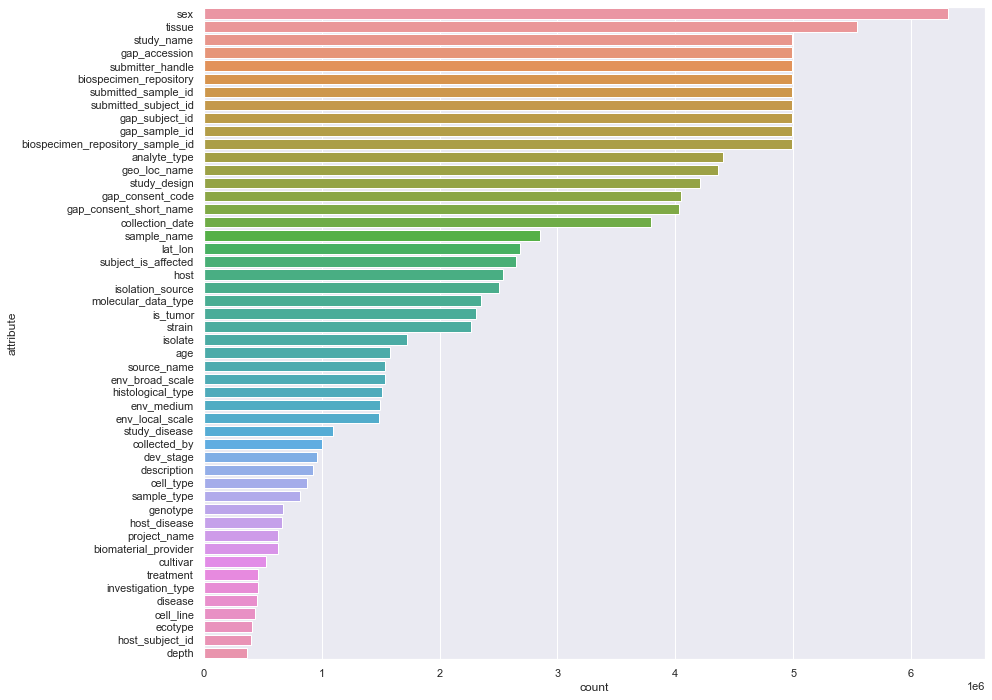

In [103]:
%matplotlib inline
sns.set()

plt.figure(figsize=(14,12))

ax = sns.barplot(y='attribute', x='count', data=top50Df) # note plot is on its side
xticks = [''] * 447
# ax.set_xticklabels(xticks, size=1)
plt.show()

## implement SAX parser
see https://www.tutorialspoint.com/python3/python_xml_processing.htm for an example
took around 40 minutes to run on my machine

In [110]:
import xml
from xml.sax import ContentHandler

In [153]:
class BiosampleHandler( ContentHandler ):
    def __init__(self):
        self.dataDict = {}
        self.CurrentData = ""
        self.attribute = ""
        self.biosample = ""
        self.harmonized_name = ""
        self.harmonized_value = ""
        
    def startElement(self, tag, attributes):
        self.CurrentData = tag
        if tag == "BioSample":
            if 'BioSample' in self.dataDict.keys():
                self.dataDict['BioSample'] = (self.dataDict['BioSample'] + 1)
            else:
                self.dataDict['BioSample'] = 1
#             print('***** BioSample *****')
            
        if tag == "Attribute" and ('harmonized_name' in attributes):
            self.harmonized_name = attributes['harmonized_name']
            if self.harmonized_name in self.dataDict.keys():
                self.dataDict[self.harmonized_name] = (self.dataDict[self.harmonized_name] + 1)
            else:
                self.dataDict[self.harmonized_name] = 1


    def endElement(self, tag):
        if self.CurrentData == "Attribute" and len(self.harmonized_name) > 0:
#             print (f"{self.harmonized_name}: {self.harmonized_value}")
            self.harmonized_name = ""
    
    def characters(self, content):
        if self.CurrentData == "Attribute" and len(self.harmonized_name) > 0:
            self.harmonized_value = content
    

In [162]:
# create an XMLReader
parser = xml.sax.make_parser()
    
# turn off namepsaces
parser.setFeature(xml.sax.handler.feature_namespaces, 0)

# override the default ContextHandler
handler = BiosampleHandler()
parser.setContentHandler( handler )

In [163]:
# parser.parse("../../downloads/test-biosample.xml") # test-biosample.xml contains first 637 lines from biosample_set.xml
parser.parse("../../downloads/biosample_set.xml")

### count number of biosample tag occurrences
#### datafame analysis found 13791009; why the difference? 
#### I "think" it is b/c some xml biosample records don't have any harmonized attributes, and the xml parse still counts this. Here is an example:
```xml
<BioSample submission_date="2008-04-04T08:44:29.030" last_update="2014-03-17T12:37:44.407" publication_date="2008-04-04T08:44:29.250" access="public" id="13" accession="SAMN00000013">
  <Ids>
    <Id db="BioSample" is_primary="1">SAMN00000013</Id>
    <Id db="WUGSC" db_label="Sample name">Physarum polycephalum</Id>
    <Id db="SRA">SRS000013</Id>
  </Ids>
  <Description>
    <Title>Generic sample from Physarum polycephalum</Title>
    <Organism taxonomy_id="5791" taxonomy_name="Physarum polycephalum"/>
    <Comment>
      <Paragraph>DNA is in house and was prepared from haploid amoebe provided by the laboratory of Gerard Pierrion.</Paragraph>
    </Comment>
  </Description>
  <Owner>
    <Name abbreviation="WUGSC">Washington University, Genome Sequencing Center</Name>
    <Contacts>
      <Contact email="lims@genome.wustl.edu"/>
    </Contacts>
  </Owner>
  <Models>
    <Model>Generic</Model>
  </Models>
  <Package display_name="Generic">Generic.1.0</Package>
  <Attributes/>
  <Links>
    <Link type="entrez" target="bioproject" label="PRJNA12851">12851</Link>
  </Links>
  <Status status="live" when="2014-03-17T12:37:44"/>
</BioSample>
```

### when I query the dataframe representation, biosample SAMN00000013 is not found

In [171]:
df.query("biosample == 'SAMN00000013'")

,biosample,attribute,value


In [164]:
handler.dataDict['BioSample']

14300583

### count number of env_broad_scale attribute occurrences
#### dataframe anayis above found 1537375; why the difference?

In [166]:
handler.dataDict['env_broad_scale'] 

1569754

In [172]:
len(df.query("attribute == 'env_broad_scale'"))

1537375